# Análise de inadimplência em cartões de crédito

Notebook em R baseado no repositório `gabrielftonello/default-credit-card-clients` e no Dataset `https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data`.


Este notebook segue, em linhas gerais, o fluxo do projeto original em R:

1. Carregamento dos pacotes e dos dados.
2. Análise exploratória (EDA).
3. Redução de dimensionalidade via PCA.
4. Seleção de variáveis com algoritmo genético.
5. Ajuste e avaliação de uma regressão logística.
6. Avaliação de limiares de decisão e curvas ROC.


In [ ]:

# -----------------------------
# 1. Pacotes e carregamento dos dados
# -----------------------------

# Instalação automática de pacotes que faltarem
req_packages <- c(
  "readxl", "dplyr", "ggplot2", "scales",
  "caret", "pROC", "GA", "FactoMineR", "factoextra"
)

for (pkg in req_packages) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
    library(pkg, character.only = TRUE)
  }
}

# Caminho do arquivo de dados (como no repositório)
# data/default_credit_card_clients.xls
dados_raw <- readxl::read_excel("data/default_credit_card_clients.xls")

# Renomeia a variável de resposta para algo mais prático
# (no dataset original ela se chama default.payment.next.month)
dados <- dados_raw %>%
  dplyr::rename(
    DEFAULT = default.payment.next.month
  ) %>%
  dplyr::mutate(
    DEFAULT = factor(DEFAULT, levels = c(0, 1),
                     labels = c("Nao", "Sim"))
  )

str(dados)
summary(dados$DEFAULT)


## 2. Análise exploratória

### 2.1 Limite de crédito por status de default

O gráfico abaixo mostra como o limite de crédito (**LIMIT_BAL**) se distribui entre clientes que **não** deram default (0) e os que **deram** default (1).

A ideia é responder perguntas como:

- Clientes inadimplentes tendem a ter limites menores ou maiores?
- A distribuição é muito assimétrica? Há muitos outliers?


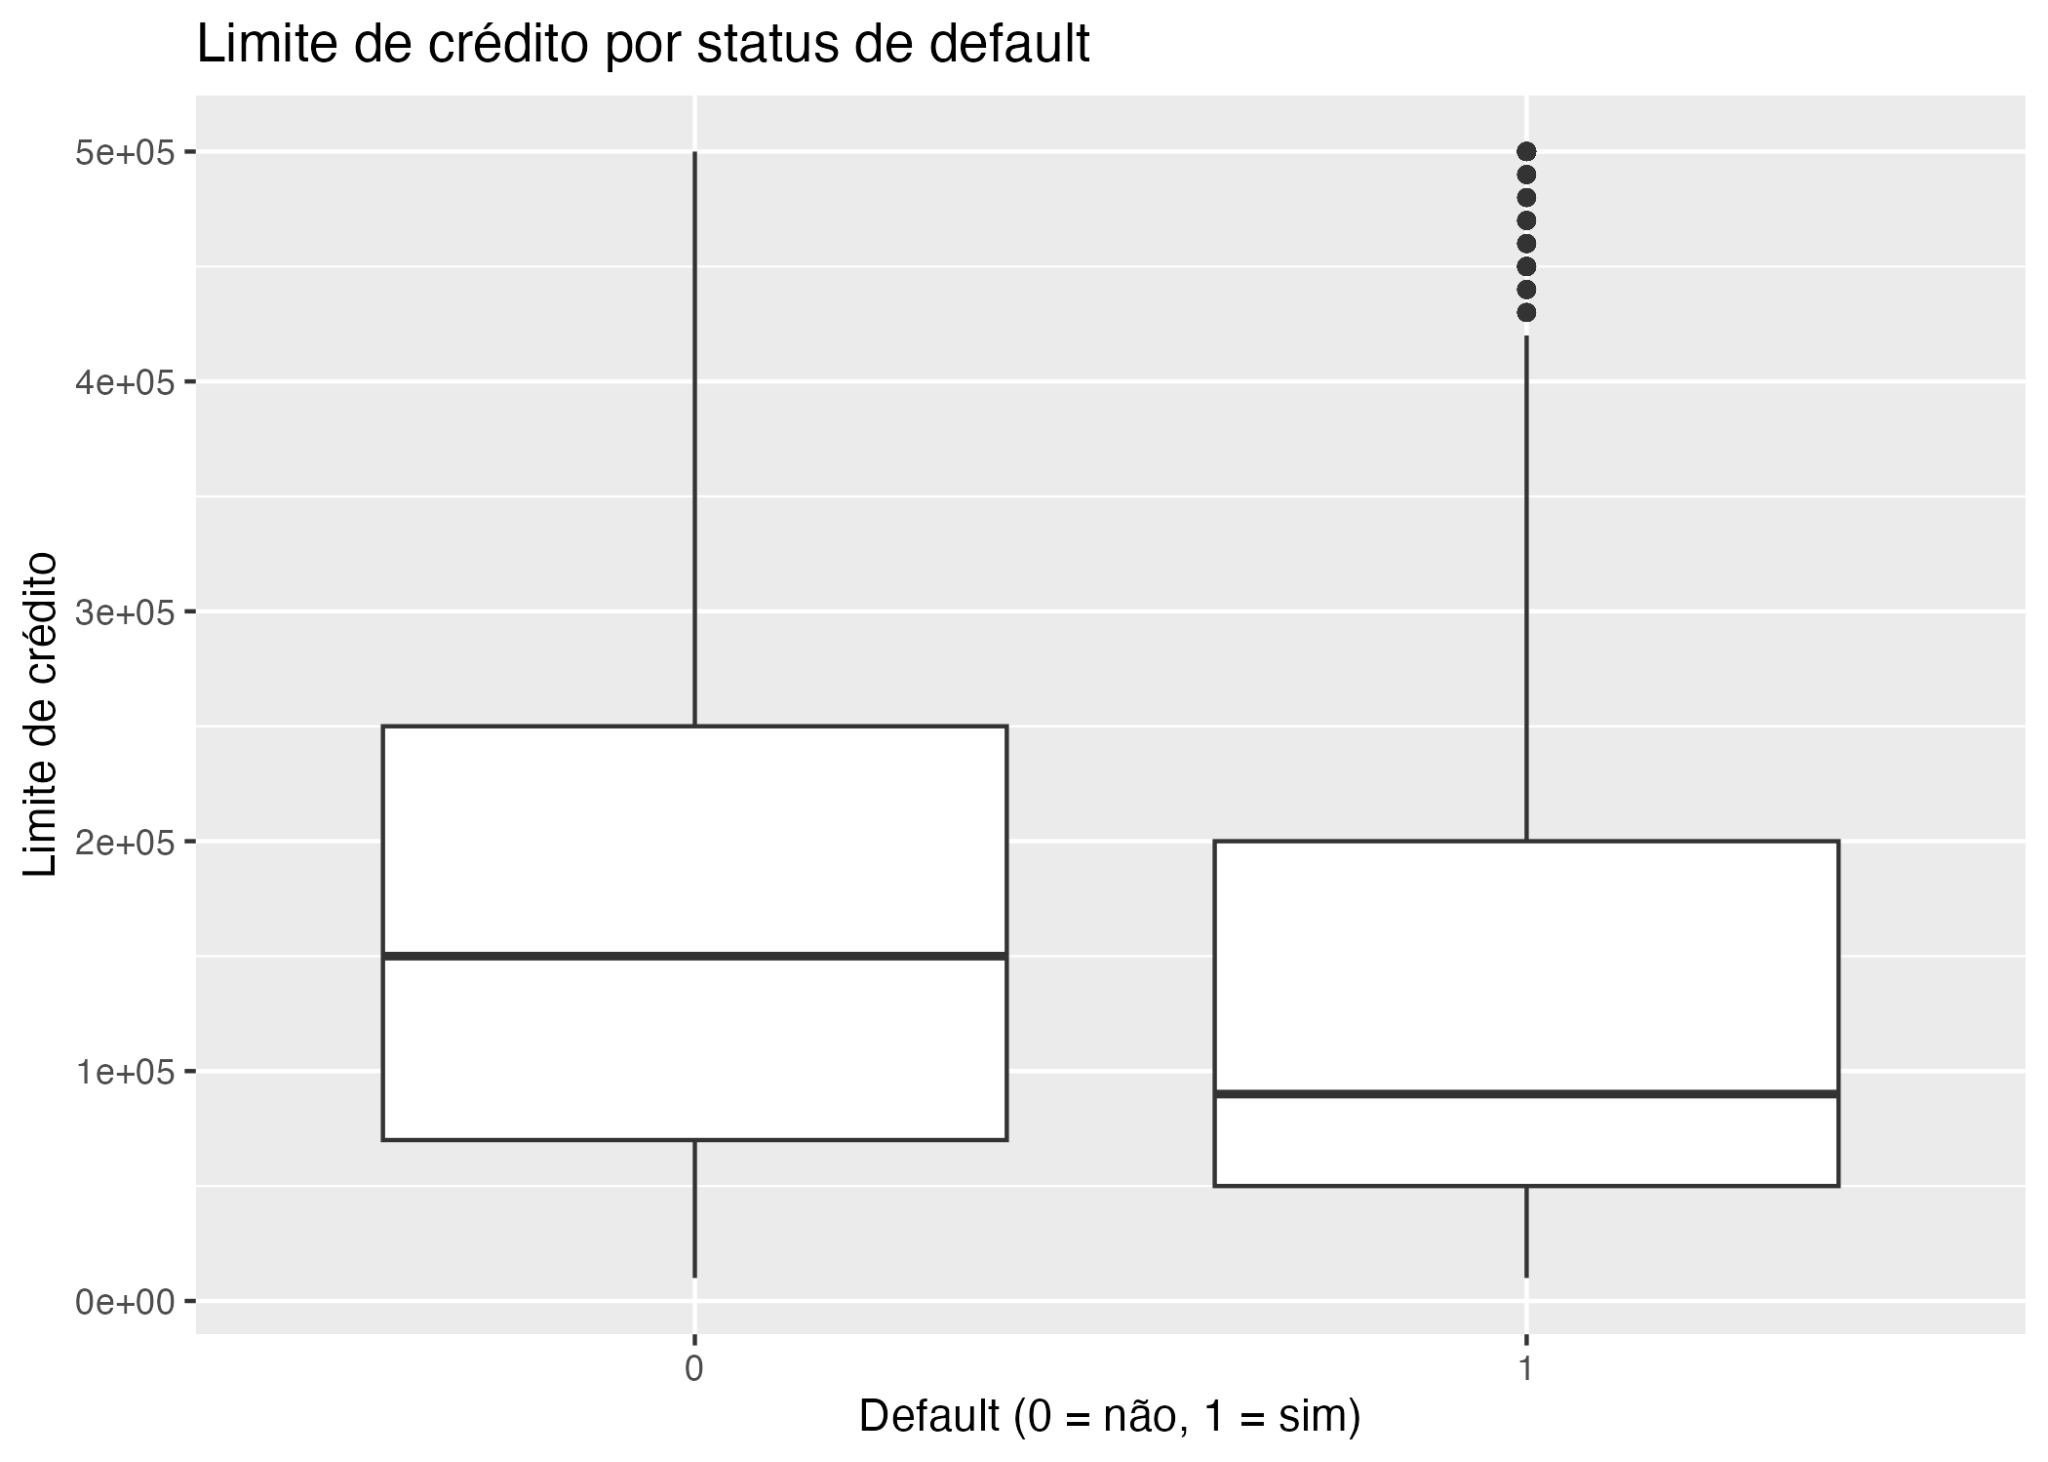

*Limite de crédito por status de default*

In [ ]:

# Boxplot do limite de crédito por status de default
ggplot(dados, aes(x = as.factor(DEFAULT), y = LIMIT_BAL)) +
  geom_boxplot(fill = "white") +
  scale_y_continuous(labels = scales::comma) +
  labs(
    x = "Default (0 = não, 1 = sim)",
    y = "Limite de crédito",
    title = "Limite de crédito por status de default"
  ) +
  theme_bw()



**Interpretação do boxplot**

- A mediana do limite de crédito para clientes **sem default (0)** é maior do que para os clientes **com default (1)**.
- Em ambos os grupos existe uma cauda longa para limites muito altos, com vários **outliers**.
- Isso sugere que, em média, **clientes com limites mais elevados tendem a inadimplir menos**, ainda que existam inadimplentes em praticamente toda a faixa de limite.


### 2.2 Distribuição da idade dos clientes

Aqui analisamos a distribuição da **idade (AGE)** para todos os clientes.

Questões principais:

- Em quais faixas etárias há mais clientes?
- A distribuição é simétrica ou enviesada?


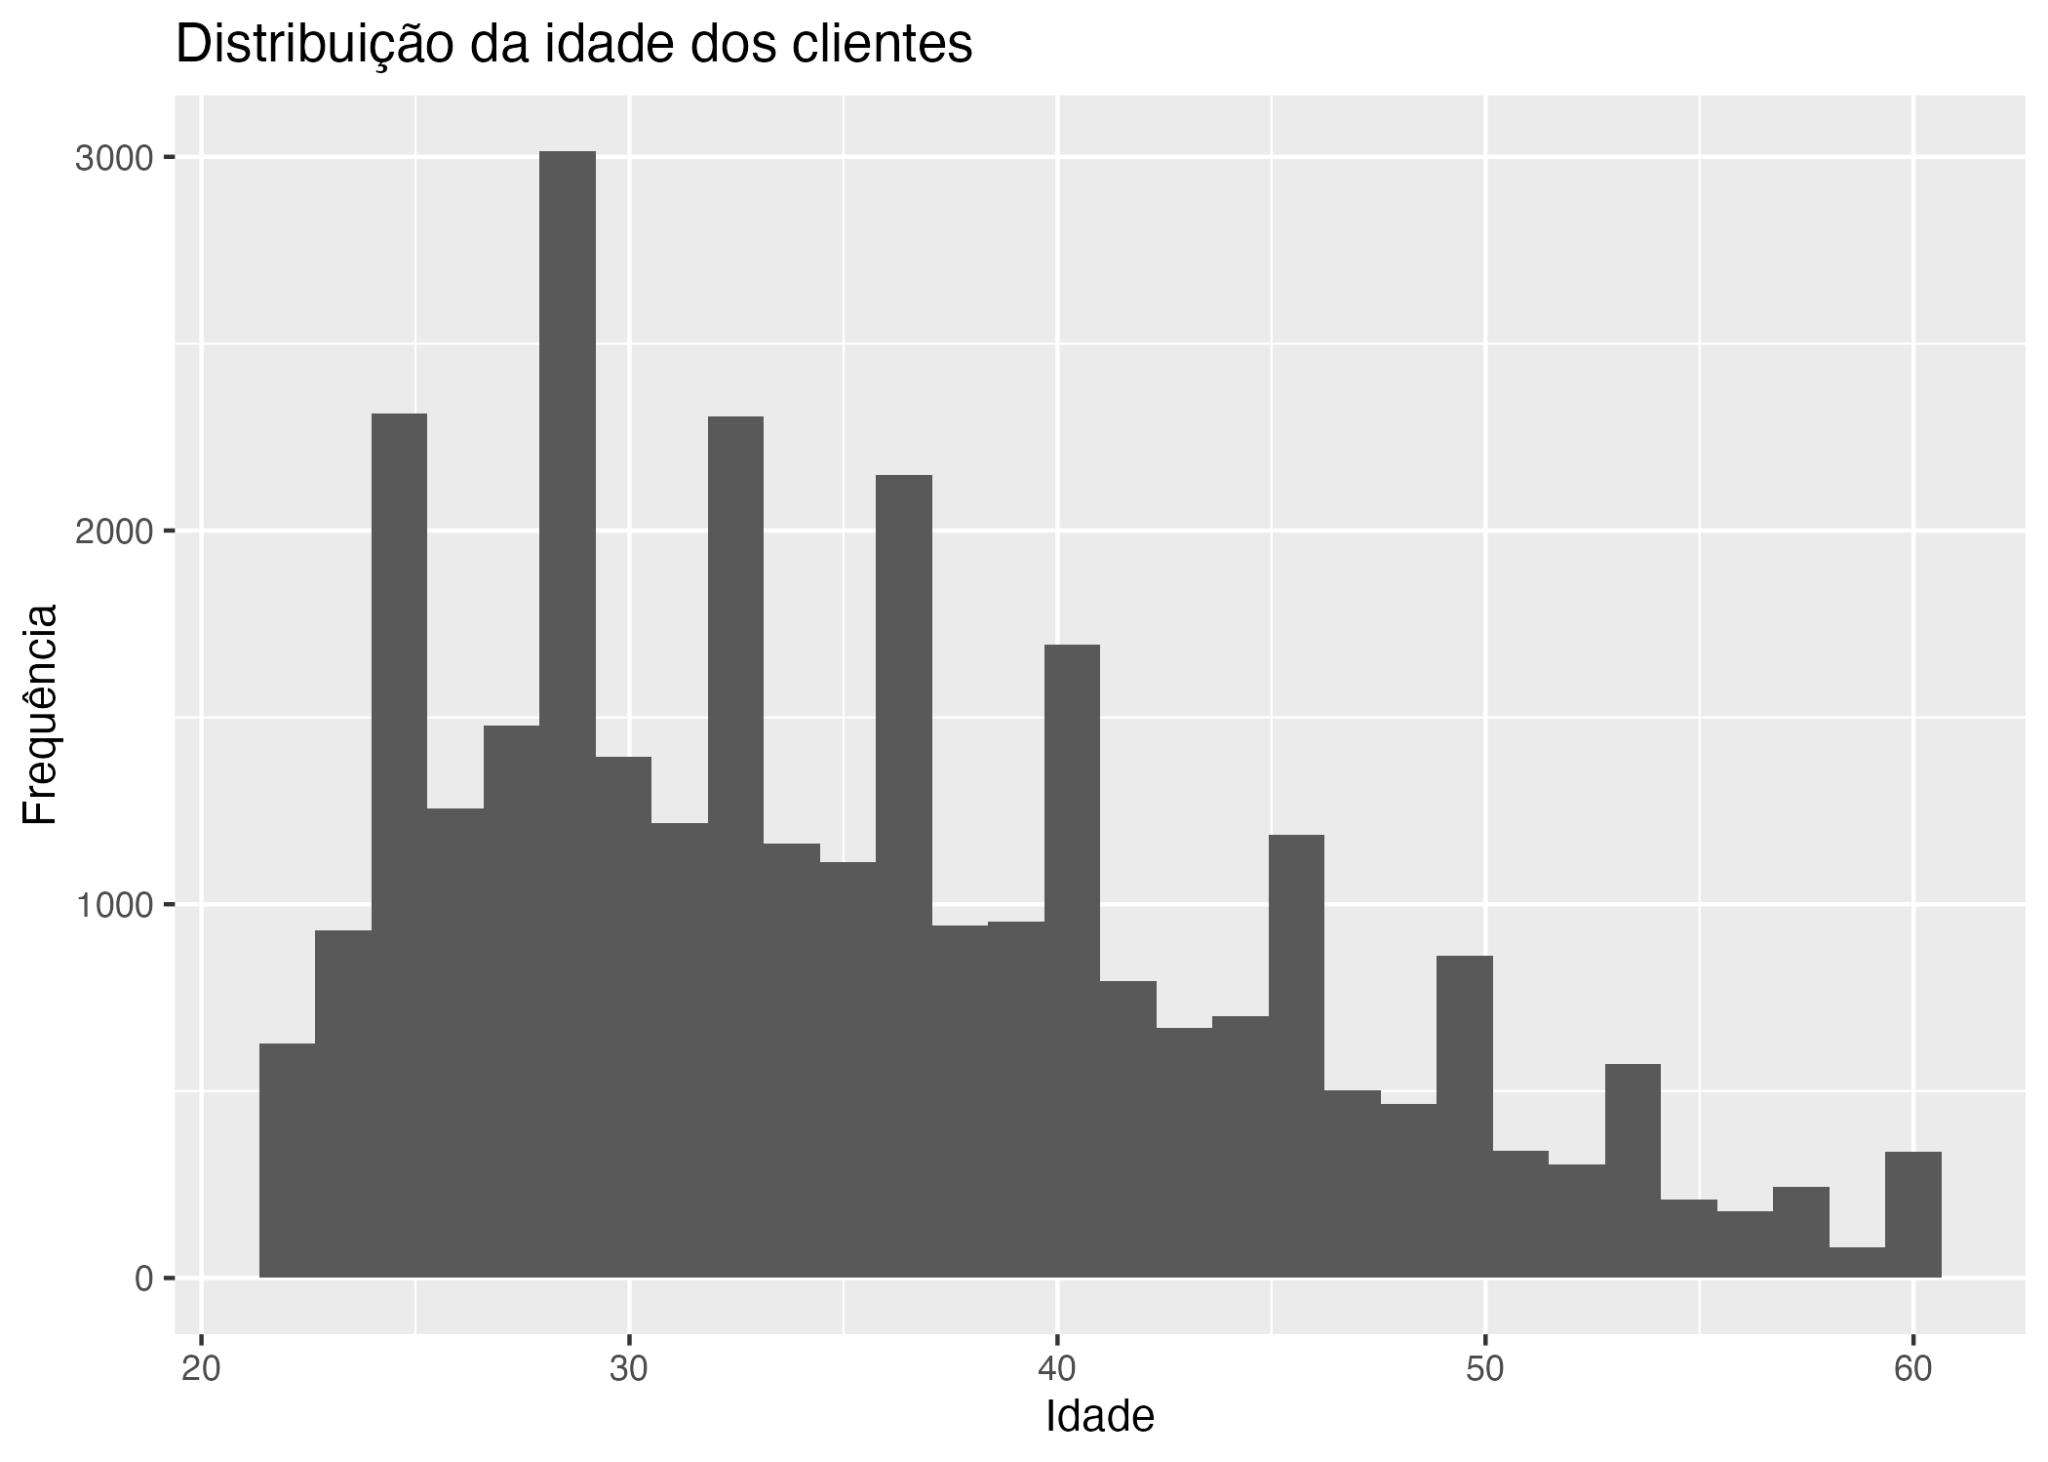

*Distribuição da idade dos clientes*

In [ ]:

# Histograma da idade
ggplot(dados, aes(x = AGE)) +
  geom_histogram(binwidth = 1, colour = "white") +
  labs(
    x = "Idade",
    y = "Frequência",
    title = "Distribuição da idade dos clientes"
  ) +
  theme_bw()



**Interpretação do histograma**

- A maior concentração de clientes está entre **25 e 40 anos**, com pico em torno do final dos 20/início dos 30.
- Há menos observações em idades mais avançadas (acima de 50 anos).
- Do ponto de vista de risco, isso indica que o portfólio é dominado por **adultos jovens**, o que influenciará todas as estatísticas de default.


## 3. Seleção de variáveis com algoritmo genético (GA)


A etapa de seleção de variáveis busca encontrar um subconjunto de *features* que produza um modelo de regressão logística com bom desempenho, sem usar todas as variáveis disponíveis.

Foi utilizado um **algoritmo genético** (pacote `GA`) onde:

- cada *indivíduo* na população representa um subconjunto de variáveis (cromossomo binário),
- a **função de fitness** é baseada na performance (por exemplo, AUC ou log-verossimilhança) da regressão logística em validação cruzada,
- o GA evolui a população por algumas gerações até convergir.


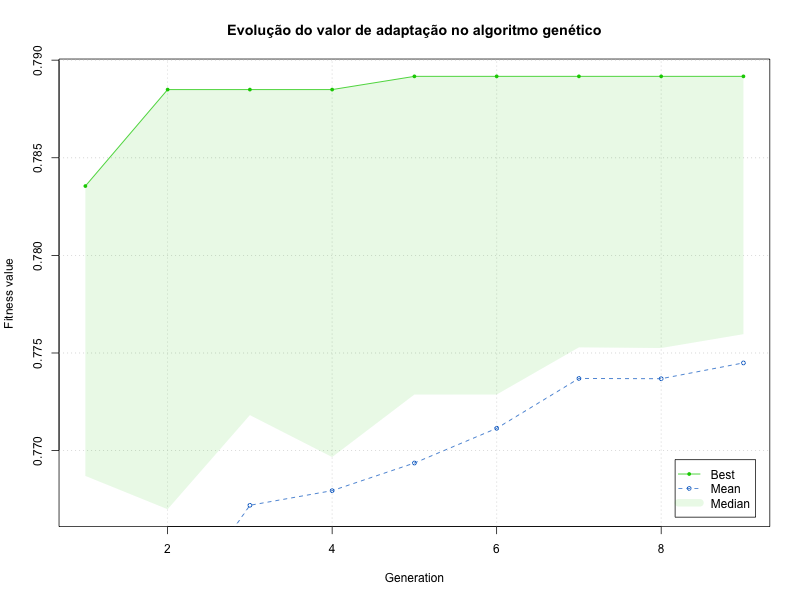

*Evolução do valor de adaptação (fitness) no algoritmo genético*

In [ ]:

# -----------------------------
# 3. Exemplo de GA para seleção de variáveis
# -----------------------------

# Fórmula completa (todas as variáveis explicativas, exceto ID e DEFAULT)
vars_explicativas <- setdiff(names(dados), c("ID", "DEFAULT"))
formula_base <- as.formula(
  paste("DEFAULT ~", paste(vars_explicativas, collapse = " + "))
)

# Função de fitness: AUC médio em validação cruzada
fitness_logit <- function(bits) {
  # bits: vetor 0/1 indicando se a variável entra ou não
  if (sum(bits) == 0) return(0)  # evita modelo vazio

  vars_sel <- vars_explicativas[bits == 1]
  form <- as.formula(
    paste("DEFAULT ~", paste(vars_sel, collapse = " + "))
  )

  # validação cruzada
  ctrl <- caret::trainControl(
    method = "cv",
    number = 5,
    classProbs = TRUE,
    summaryFunction = twoClassSummary,
    verboseIter = FALSE
  )

  set.seed(123)
  modelo_cv <- caret::train(
    form, data = dados,
    method = "glm",
    family = binomial,
    trControl = ctrl,
    metric = "ROC"
  )

  # retorna o ROC médio (AUC)
  modelo_cv$results$ROC
}

set.seed(123)
ga_res <- GA::ga(
  type = "binary",
  nBits = length(vars_explicativas),
  fitness = fitness_logit,
  maxiter = 10,          # número de gerações (aumentar na prática)
  popSize = 30,          # tamanho da população
  pmutation = 0.1,
  pcrossover = 0.8,
  keepBest = TRUE,
  seed = 123
)

# Plot da convergência (similar ao exibido na figura)
plot(ga_res, main = "Evolução do valor de adaptação no algoritmo genético")



**Interpretação do gráfico de convergência do GA**

- A curva mostra que o **melhor valor de fitness** sobe rapidamente nas primeiras gerações e depois estabiliza.
- Isso indica que o GA encontrou um conjunto de variáveis com desempenho razoavelmente estável — novas gerações não trazem ganhos relevantes.
- A distância entre a linha do **melhor indivíduo** e da **média da população** mostra o quão heterogêneos são os cromossomos; à medida que o algoritmo converge, essa diferença tende a diminuir.


## 4. Regressão logística com variáveis selecionadas


Uma vez escolhido o subconjunto de variáveis pelo GA, ajustamos um modelo de **regressão logística binária** para prever a probabilidade de default.

Abaixo, temos um gráfico com os **20 coeficientes de maior magnitude**, em escala de **log-odds**.


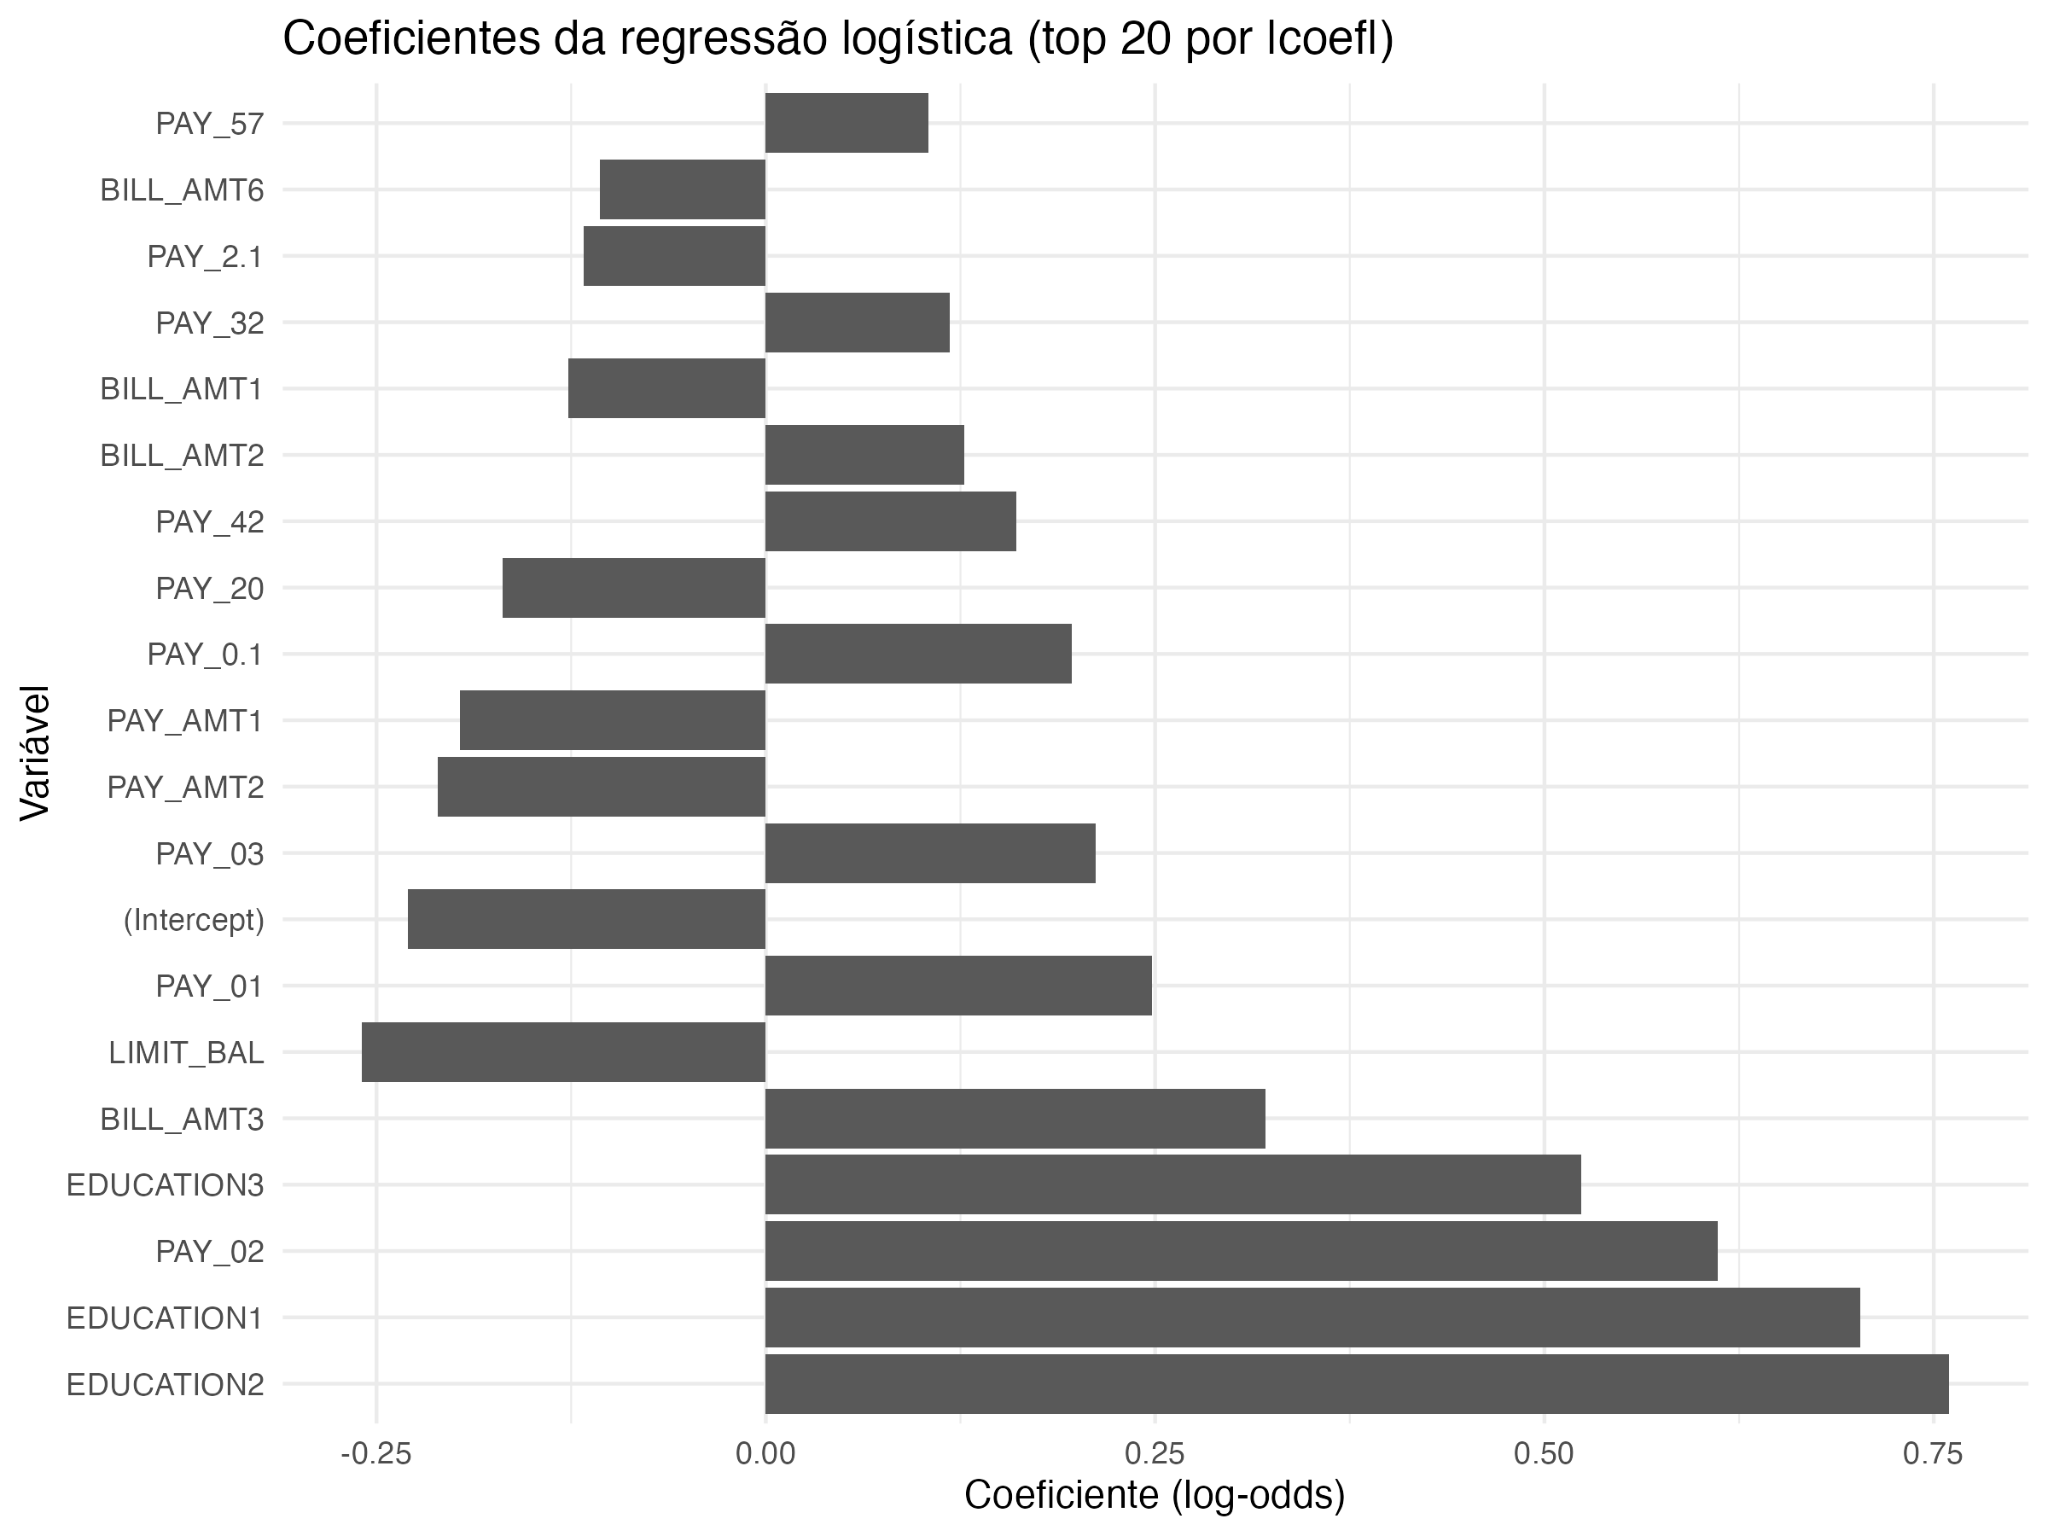

*Coeficientes da regressão logística (top 20 por |coef|)*

In [ ]:

# -----------------------------
# 4. Ajuste do modelo logístico
# -----------------------------

# Exemplo: extraindo a melhor solução do GA
best_bits <- ga_res@solution[1, ]
vars_sel <- vars_explicativas[best_bits == 1]

form_final <- as.formula(
  paste("DEFAULT ~", paste(vars_sel, collapse = " + "))
)

set.seed(123)
mod_logit <- glm(form_final, data = dados, family = binomial)

summary(mod_logit)

# Tabela de coeficientes ordenada por |coef|
coefs <- broom::tidy(mod_logit) %>%
  dplyr::filter(term != "(Intercept)") %>%
  dplyr::mutate(abs_est = abs(estimate)) %>%
  dplyr::arrange(dplyr::desc(abs_est)) %>%
  dplyr::slice(1:20)

# Gráfico dos 20 maiores coeficientes em módulo
ggplot(coefs, aes(x = reorder(term, estimate), y = estimate)) +
  geom_col() +
  coord_flip() +
  labs(
    x = "Variável",
    y = "Coeficiente (log-odds)",
    title = "Coeficientes da regressão logística (top 20 por |coef|)"
  ) +
  theme_bw()



**Interpretação dos coeficientes**

- Coeficientes **positivos** aumentam o log-odds (e, portanto, a probabilidade) de default quando a variável cresce.
- Coeficientes **negativos** reduzem a probabilidade de default.
- Valores com maior |coeficiente| têm maior impacto no risco, mantendo as demais variáveis constantes.
- Tipicamente aparecem entre as mais importantes:
  - Indicadores de **atraso de pagamento** (`PAY_XX`),
  - Saldos de fatura (`BILL_AMTX`),
  - Valores de pagamento (`PAY_AMTX`),
  - Níveis de educação (`EDUCATIONX`) e o próprio **limite de crédito (`LIMIT_BAL`)**.


## 5. Matrizes de confusão no conjunto de teste


O modelo logístico gera probabilidades de default. Para transformar essas probabilidades em uma classe (0/1), precisamos definir um **limiar de decisão**.

A figura a seguir mostra duas matrizes de confusão no **conjunto de teste**:

- à esquerda, um limiar **agressivo**, priorizando **sensibilidade** ao definir uma sensibilidade mínima de 0.75 (pegar o máximo de inadimplentes);
- à direita, um limiar mais **equilibrado**, próximo do que maximiza a **F1**.


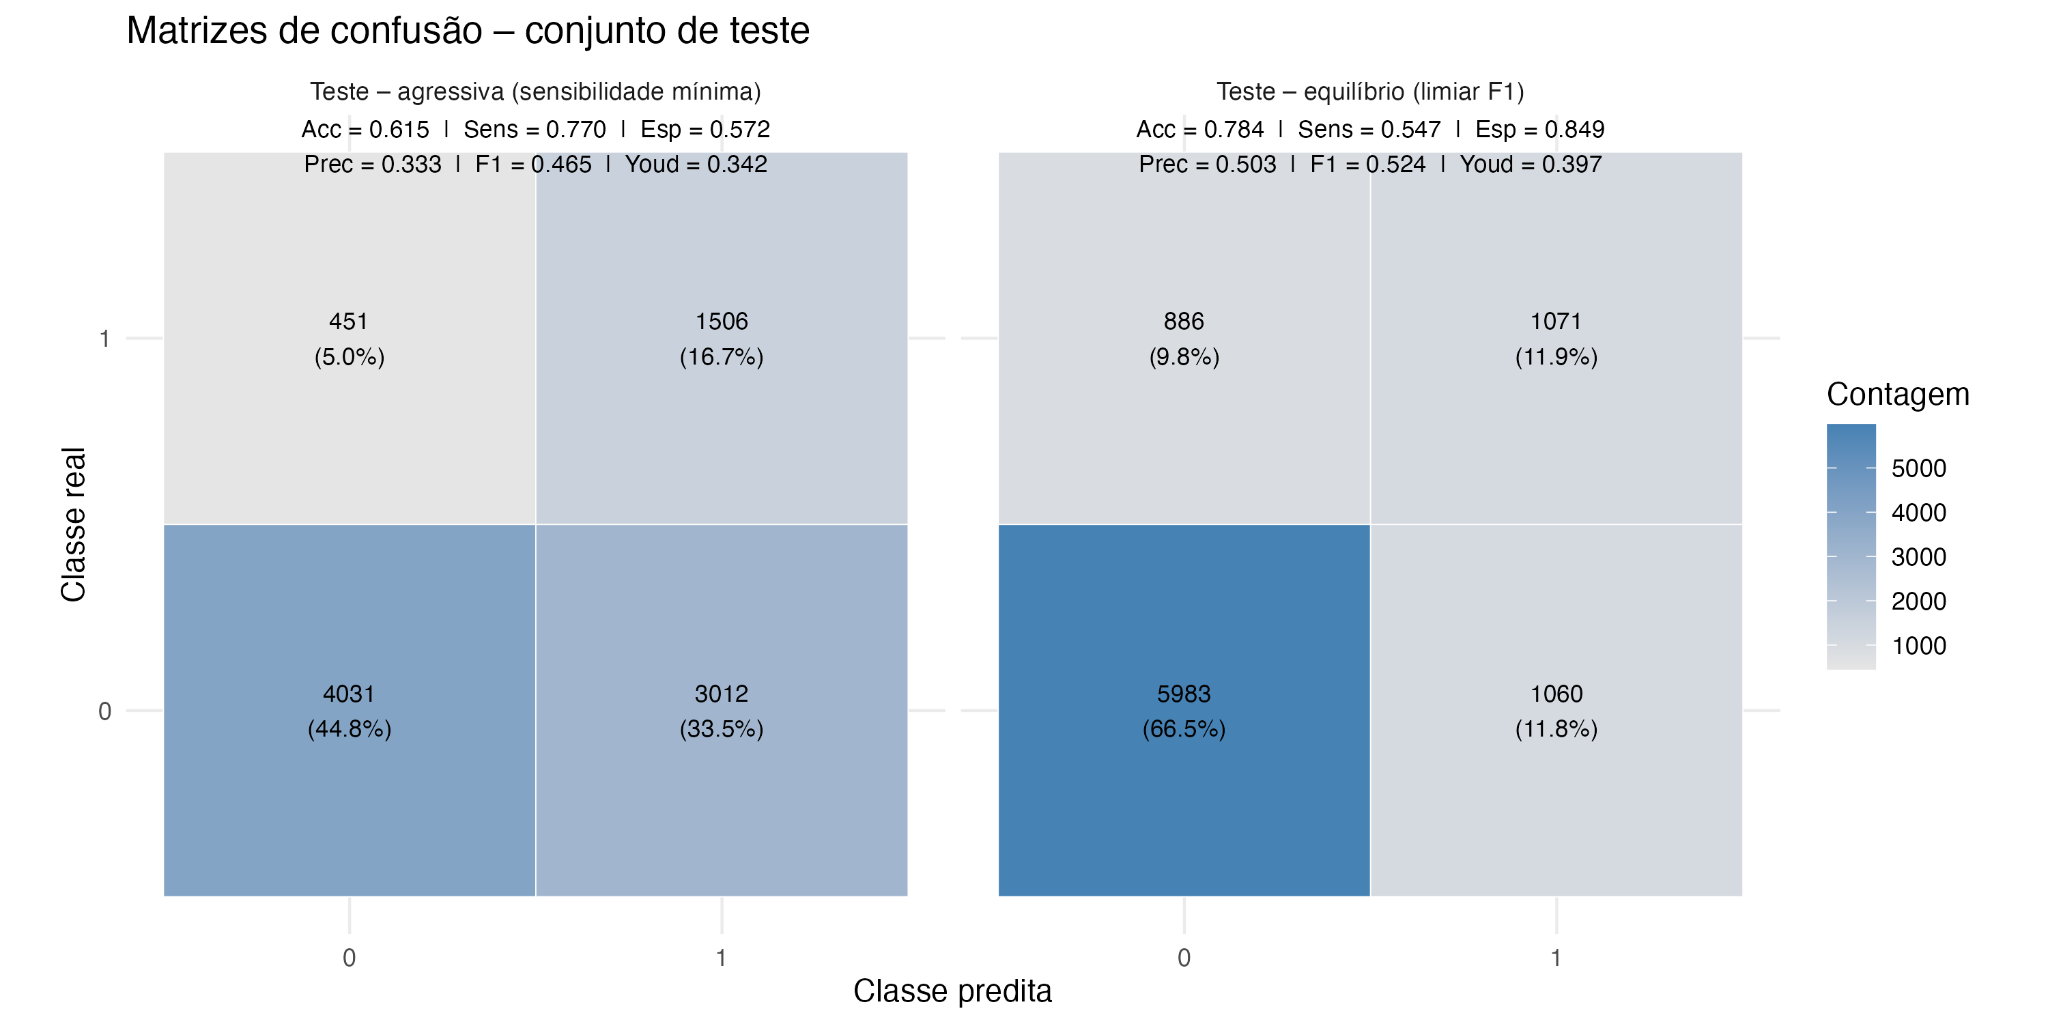

*Matrizes de confusão – conjunto de teste*

In [ ]:

# -----------------------------
# 5. Conjunto de treino/teste e matrizes de confusão
# -----------------------------

set.seed(123)
idx_treino <- caret::createDataPartition(dados$DEFAULT, p = 0.7, list = FALSE)
treino <- dados[idx_treino, ]
teste  <- dados[-idx_treino, ]

# Reajusta o modelo apenas nos dados de treino
mod_logit_tr <- glm(form_final, data = treino, family = binomial)

# Probabilidades previstas no teste
prob_teste <- predict(mod_logit_tr, newdata = teste, type = "response")

# Duas escolhas de limiar
limiar_agressivo <- 0.35  # prioriza sensibilidade
limiar_equilibrio <- 0.5  # mais padrão

pred_agressivo <- ifelse(prob_teste >= limiar_agressivo, "Sim", "Nao")
pred_equilibrio <- ifelse(prob_teste >= limiar_equilibrio, "Sim", "Nao")

pred_agressivo  <- factor(pred_agressivo, levels = c("Nao", "Sim"))
pred_equilibrio <- factor(pred_equilibrio, levels = c("Nao", "Sim"))

cm_agressivo <- caret::confusionMatrix(pred_agressivo, teste$DEFAULT, positive = "Sim")
cm_equilibrio <- caret::confusionMatrix(pred_equilibrio, teste$DEFAULT, positive = "Sim")

cm_agressivo
cm_equilibrio

# Visualização (exemplo simples; no projeto original usa-se um mapa de calor lado a lado)



**Interpretação das matrizes de confusão**

- No **limiar agressivo**, aumentamos a **sensibilidade** (proporção de inadimplentes corretamente identificados), ao custo de prever mais falsos positivos (clientes bons marcados como maus).
- No limiar de **equilíbrio**, a quantidade de falsos positivos diminui, mas a sensibilidade cai — alguns inadimplentes deixam de ser detectados.
- Em problemas de crédito, muitas vezes o banco prefere **aceitar mais falsos positivos** (deixar de conceder crédito para alguém que pagaria) do que **falsos negativos** (conceder crédito a alguém que não paga).


## 6. Métricas em função do limiar de decisão


Para entender melhor o impacto do limiar, podemos calcular várias métricas (acurácia, sensibilidade, especificidade, precisão, F1) para uma grade de valores de limiar entre 0 e 1.

O gráfico abaixo mostra como essas métricas variam.


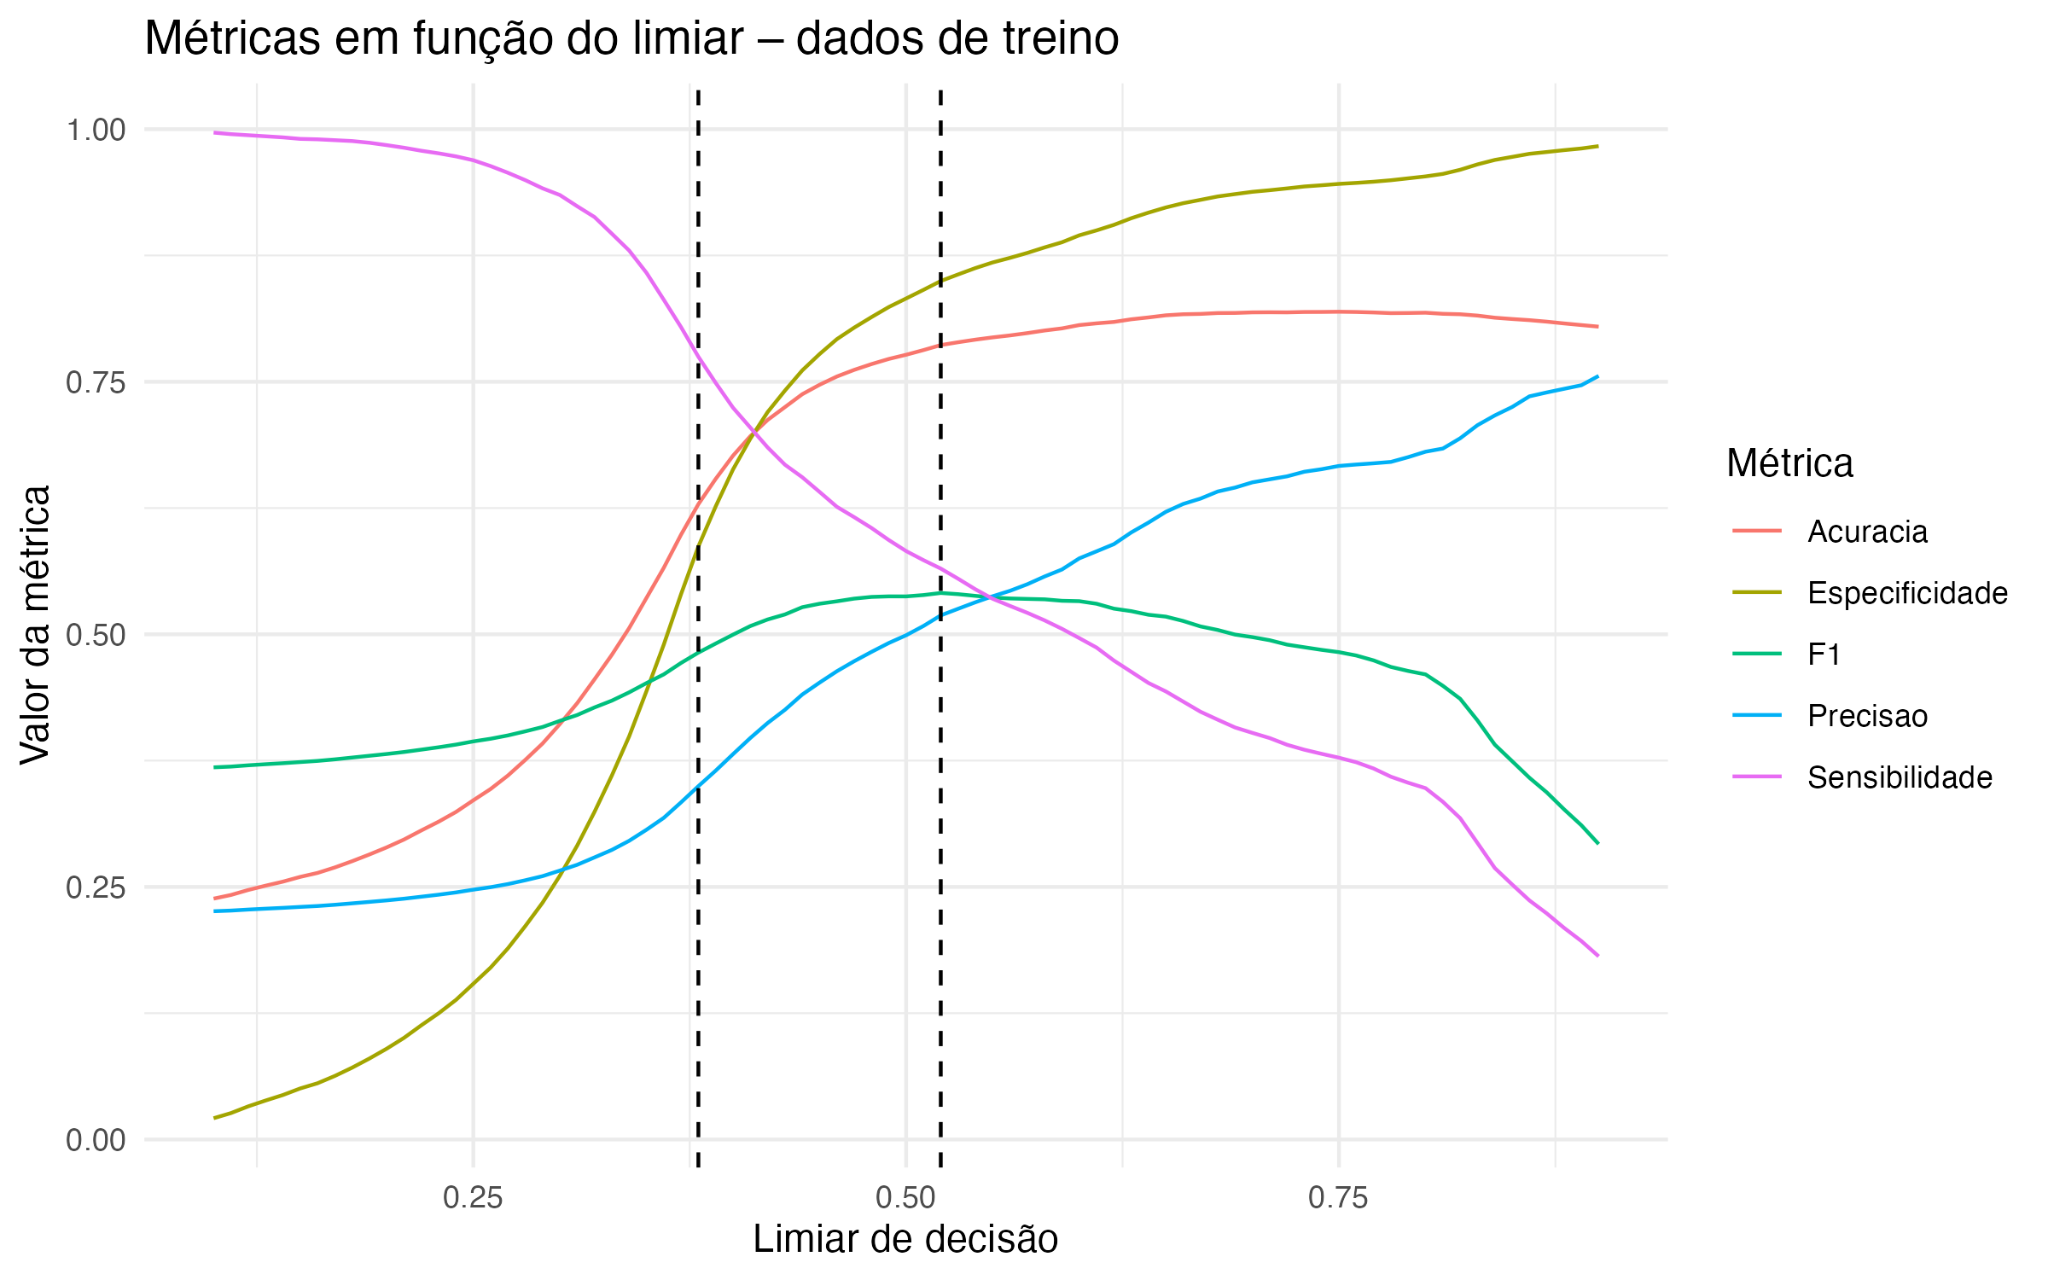

*Métricas em função do limiar – dados de treino*

In [ ]:

# -----------------------------
# 6. Curvas de métricas vs limiar
# -----------------------------

calc_metricas <- function(probs, y, limiar) {
  pred <- ifelse(probs >= limiar, "Sim", "Nao")
  pred <- factor(pred, levels = c("Nao", "Sim"))
  cm <- caret::confusionMatrix(pred, y, positive = "Sim")
  data.frame(
    limiar = limiar,
    acuracia = cm$overall["Accuracy"],
    sensibilidade = cm$byClass["Sensitivity"],
    especificidade = cm$byClass["Specificity"],
    precisao = cm$byClass["Pos Pred Value"],
    F1 = cm$byClass["F1"]
  )
}

# Probabilidades no treino
prob_treino <- predict(mod_logit_tr, newdata = treino, type = "response")

limiares <- seq(0.05, 0.95, by = 0.01)
tab_metricas <- do.call(
  rbind,
  lapply(limiares, function(l) calc_metricas(prob_treino, treino$DEFAULT, l))
)

tab_long <- tidyr::pivot_longer(
  tab_metricas,
  cols = c("acuracia", "sensibilidade", "especificidade", "precisao", "F1"),
  names_to = "metrica",
  values_to = "valor"
)

ggplot(tab_long, aes(x = limiar, y = valor, colour = metrica)) +
  geom_line(size = 1) +
  geom_vline(xintercept = c(limiar_agressivo, limiar_equilibrio),
             linetype = "dashed") +
  labs(
    x = "Limiar de decisão",
    y = "Valor da métrica",
    title = "Métricas em função do limiar – dados de treino"
  ) +
  theme_bw()



**Interpretação do gráfico de métricas**

- A **sensibilidade** começa alta para limiares baixos (quase todo mundo é classificado como inadimplente) e cai à medida que o limiar aumenta.
- A **especificidade** faz o caminho oposto: é baixa em limiares muito baixos e aumenta com o limiar.
- A **acurácia** e o **F1** costumam ter um **pico** em algum ponto intermediário.
- O **limiar agressivo** e o **limiar de equilíbrio** são marcados com linhas tracejadas; eles representam escolhas distintas de compromisso entre perder inadimplentes e recusar bons clientes.


## 7. PCA – projeção em duas dimensões


Antes da modelagem, pode ser útil visualizar a estrutura global dos dados via **Análise de Componentes Principais (PCA)**.

A figura abaixo mostra as observações projetadas nos dois primeiros componentes principais (**PC1 x PC2**), coloridas pelo status de default.


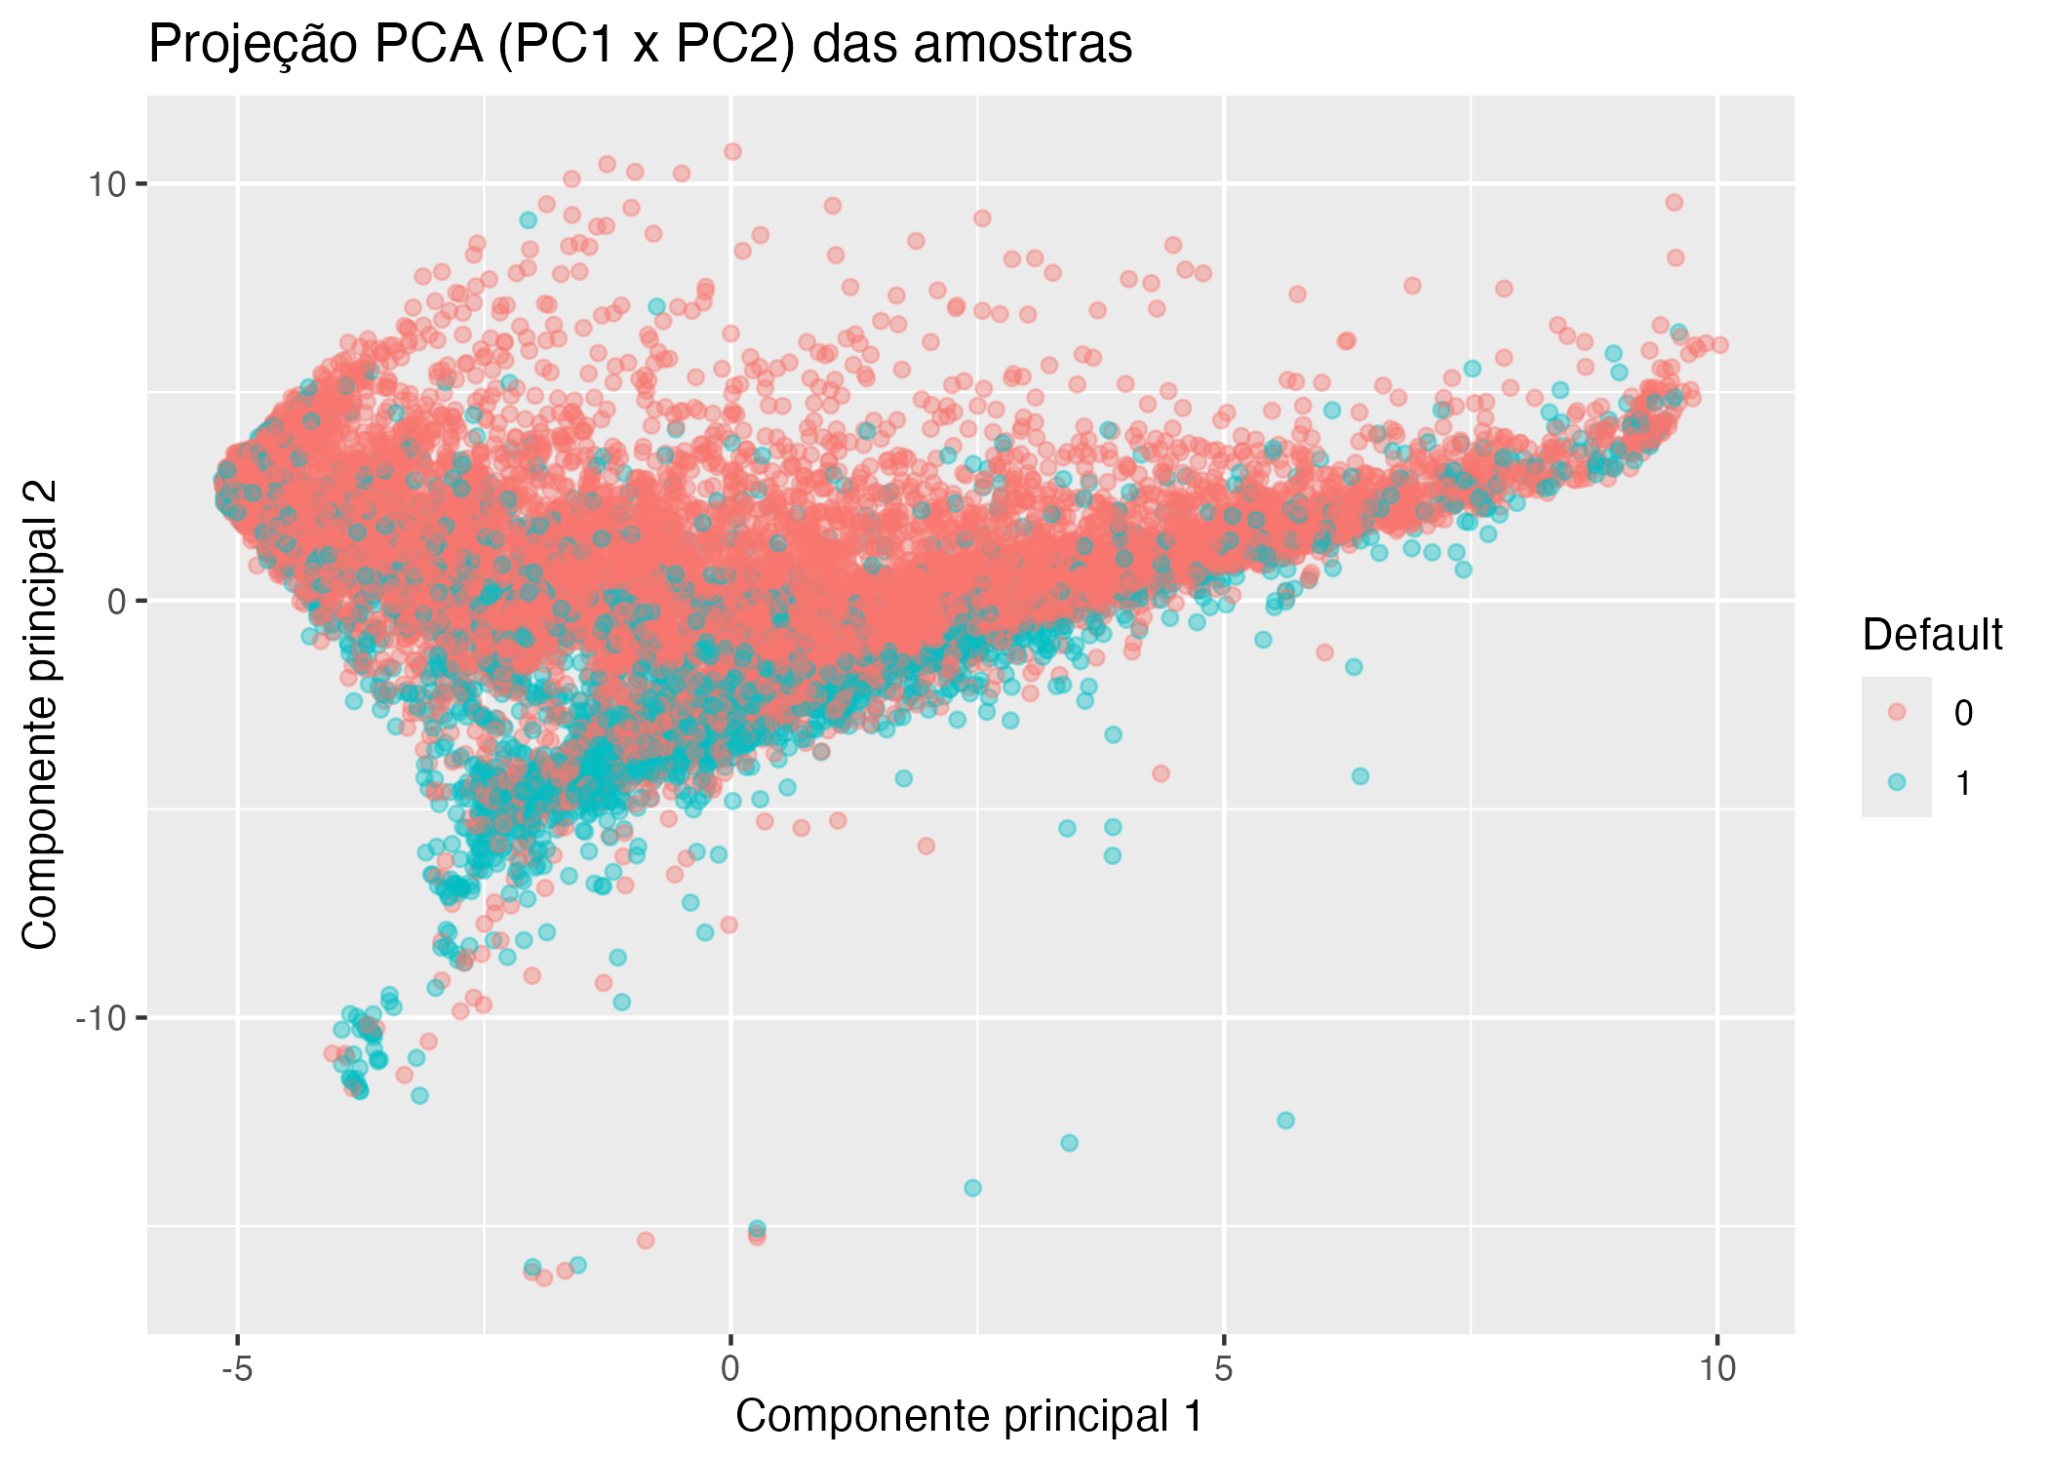

*Projeção PCA (PC1 x PC2) das amostras*

In [ ]:

# -----------------------------
# 7. PCA
# -----------------------------

# Seleciona apenas variáveis numéricas (exceto ID) para a PCA
num_vars <- dplyr::select_if(dados, is.numeric) %>%
  dplyr::select(-ID)

# PCA com padronização (centering + scaling)
pca_res <- FactoMineR::PCA(num_vars, graph = FALSE)

# Coordenadas dos indivíduos
pca_df <- as.data.frame(pca_res$ind$coord)
pca_df$DEFAULT <- dados$DEFAULT

ggplot(pca_df, aes(x = Dim.1, y = Dim.2, colour = DEFAULT)) +
  geom_point(alpha = 0.5) +
  labs(
    x = "Componente principal 1",
    y = "Componente principal 2",
    title = "Projeção PCA (PC1 x PC2) das amostras"
  ) +
  theme_bw()



**Interpretação da projeção PCA**

- As classes (default = 0 e 1) aparecem **bastante misturadas** no plano PC1 × PC2, sem uma separação clara por olho.
- Isso indica que não existe uma combinação linear simples de variáveis que separe perfeitamente bons e maus pagadores — o problema é de fato **difícil**.
- Mesmo assim, existem regiões com maior concentração de inadimplentes, o que justifica o uso de modelos probabilísticos.


### 7.1 Variância explicada pelos componentes principais

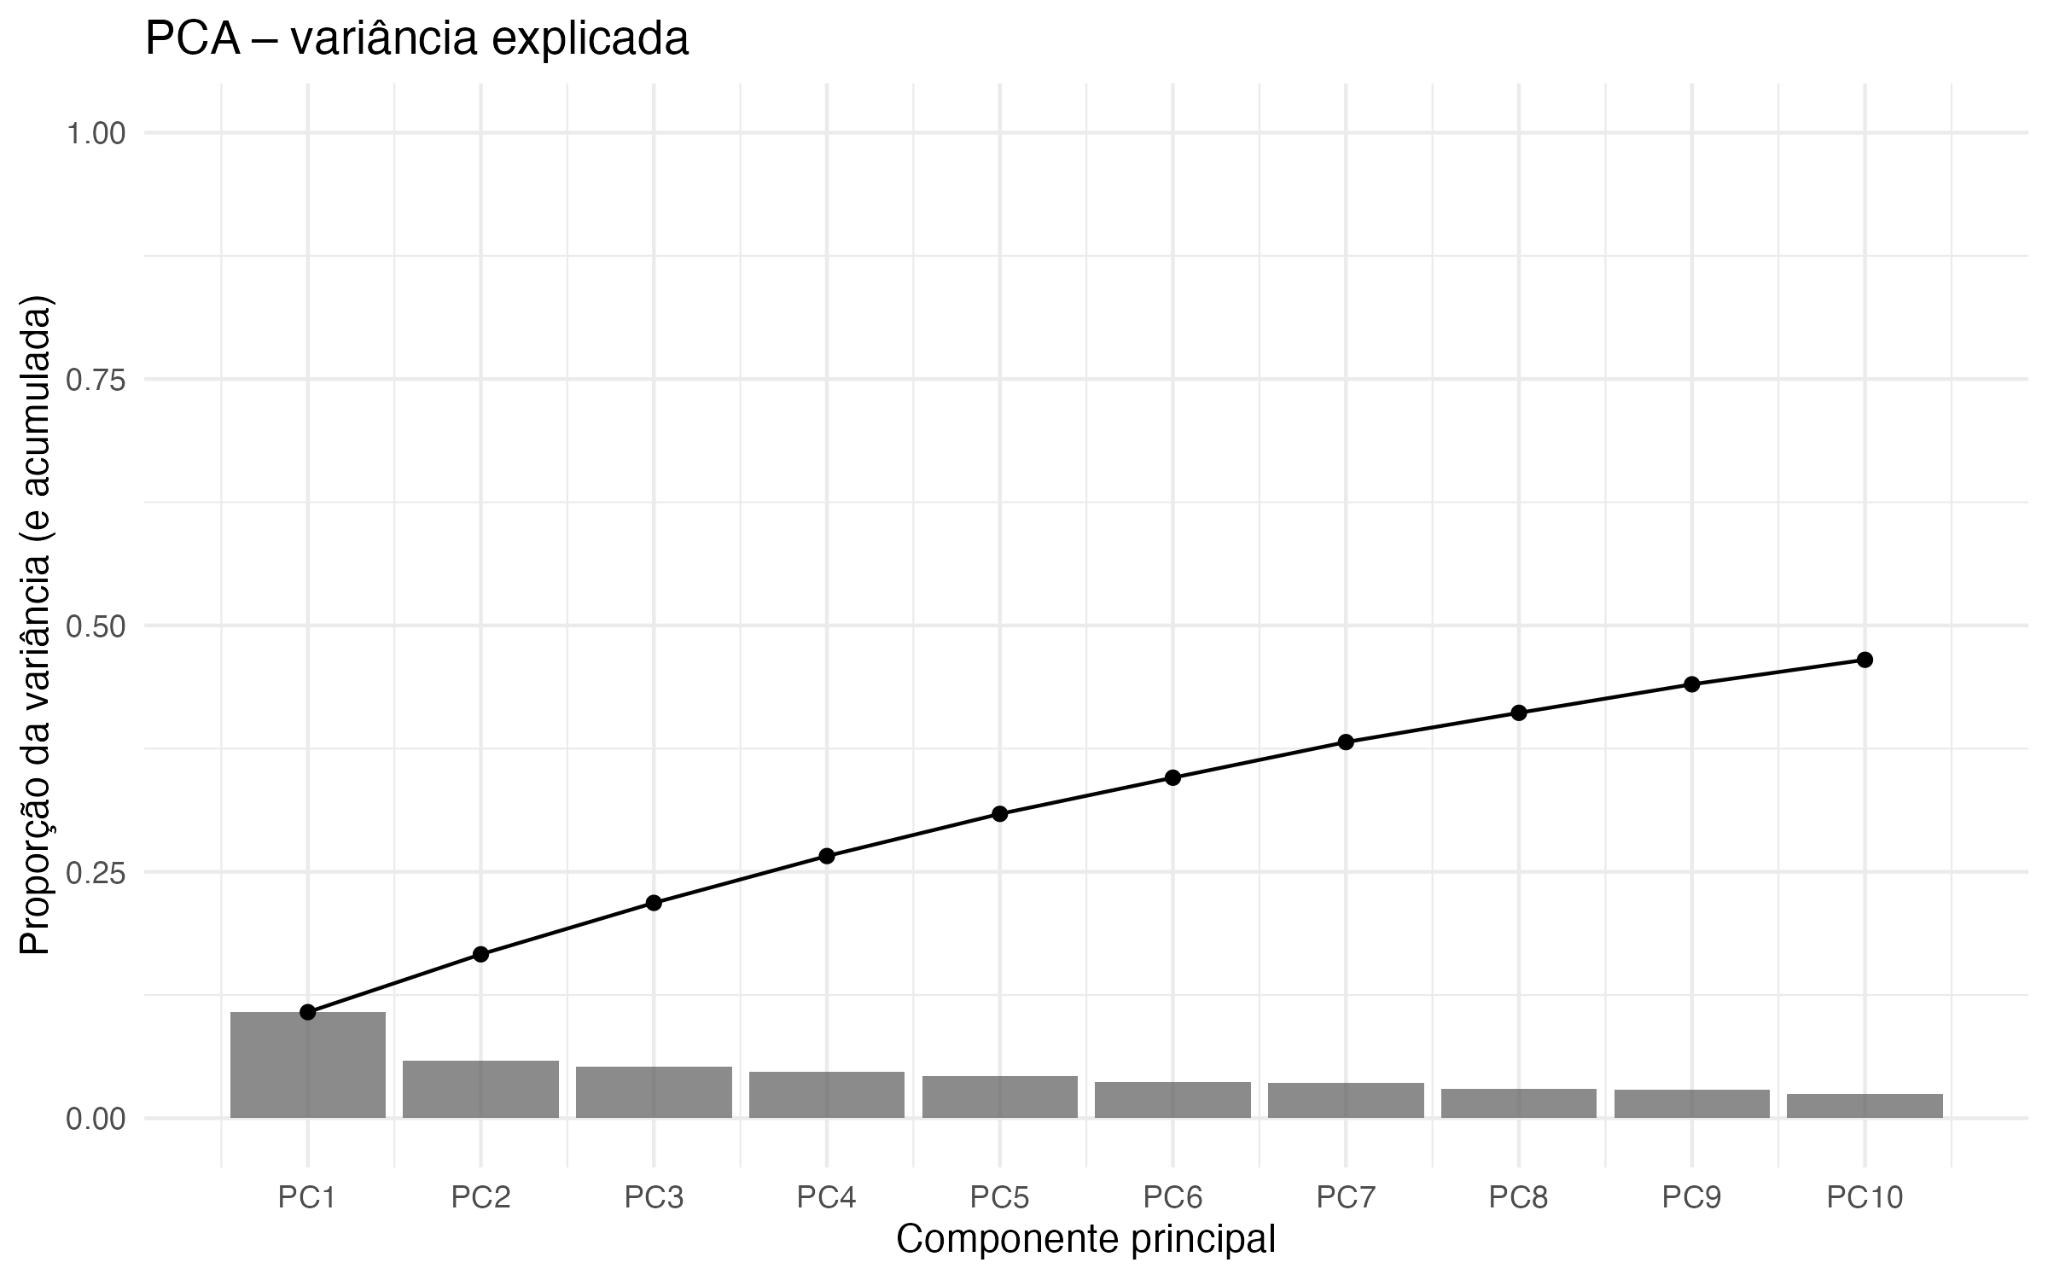

*PCA – variância explicada*

In [ ]:

# Proporção de variância explicada
var_exp <- pca_res$eig[, 2] / 100  # em proporção
var_acum <- cumsum(var_exp)

pca_var_df <- data.frame(
  PC = factor(paste0("PC", seq_along(var_exp)), levels = paste0("PC", seq_along(var_exp))),
  var_exp = var_exp,
  var_acum = var_acum
)

ggplot(pca_var_df[1:10, ], aes(x = PC, y = var_exp)) +
  geom_col() +
  geom_point(aes(y = var_acum), group = 1) +
  geom_line(aes(y = var_acum), group = 1) +
  scale_y_continuous(labels = scales::percent) +
  labs(
    x = "Componente principal",
    y = "Proporção da variância (e acumulada)",
    title = "PCA – variância explicada"
  ) +
  theme_bw()



**Interpretação da variância explicada**

- O **primeiro componente (PC1)** explica uma fração relevante da variância, mas não dominante — é comum ficar abaixo de 20%.
- A variância acumulada cresce de forma relativamente lenta; são necessários **vários componentes** para explicar uma fração grande (por exemplo, > 70%) da variância total.
- Isso reforça que o problema é **altamente multidimensional**; reduzir demais a dimensionalidade pode fazer o modelo perder informação importante.


## 8. Curvas ROC (treino e teste)


Por fim, avaliamos o modelo logístico por meio das **curvas ROC**:

- eixo x: **1 − especificidade** (ou FPR),
- eixo y: **sensibilidade** (TPR).

Quanto mais a curva se aproxima do canto superior esquerdo, melhor o modelo. O **AUC** resume a performance global.


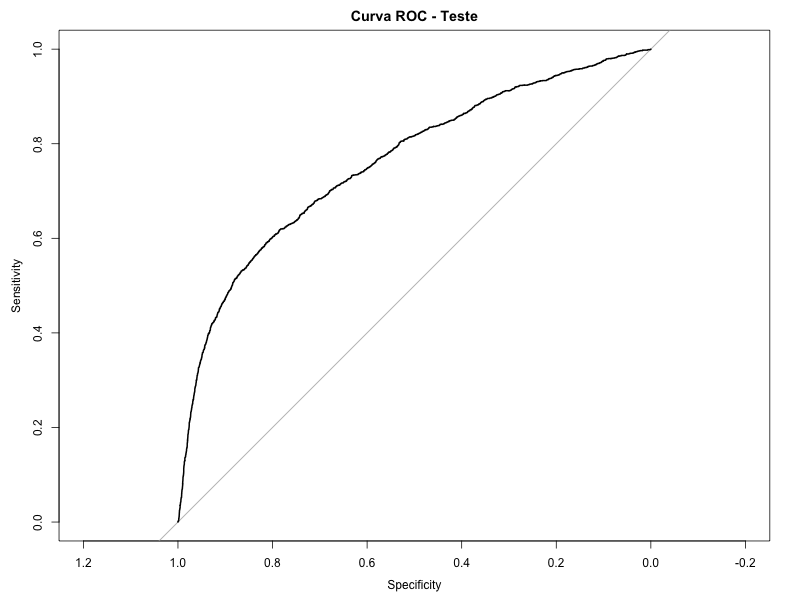

*Curva ROC - Teste*

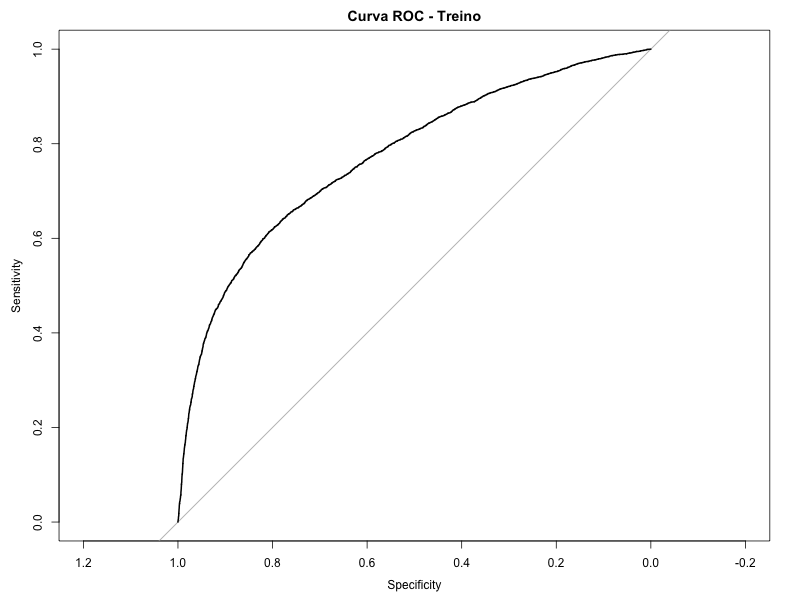

*Curva ROC - Treino*

In [ ]:

# -----------------------------
# 8. Curvas ROC
# -----------------------------

# Curva ROC no treino
roc_treino <- pROC::roc(
  response = treino$DEFAULT,
  predictor = prob_treino,
  levels = c("Nao", "Sim")
)

# Curva ROC no teste
roc_teste <- pROC::roc(
  response = teste$DEFAULT,
  predictor = prob_teste,
  levels = c("Nao", "Sim")
)

plot(roc_treino, main = "Curva ROC - Treino", col = "black")
plot(roc_teste, main = "Curva ROC - Teste", col = "black")

auc(roc_treino)
auc(roc_teste)



**Interpretação das curvas ROC**

- As curvas de treino e teste ficam **acima da diagonal aleatória**, indicando que o modelo tem capacidade de discriminar bons e maus pagadores melhor do que o acaso.
- Os valores de **AUC** costumam ficar em torno de 0,75–0,80 para esse tipo de problema – bons, mas ainda longe de perfeitos.
- A proximidade entre as curvas de treino e teste sugere que **não há overfitting extremo**: o modelo generaliza de forma razoável.


## 9. Conclusões


- O dataset de default de cartão de crédito é **complexo**, com muitas variáveis e classes relativamente desbalanceadas.
- A EDA mostra comportamentos importantes, como a relação entre **limite de crédito**, **idade** e inadimplência.
- O **PCA** revela que não há uma separação linear simples, reforçando a necessidade de modelos probabilísticos.
- A **seleção de variáveis por GA** ajuda a construir um modelo de regressão logística mais enxuto, focado nas variáveis mais informativas.
- A avaliação de **limiares de decisão** é crucial: diferentes pontos levam a diferentes compromissos entre sensibilidade, especificidade e custo de erro.
- As **curvas ROC** indicam desempenho razoável, adequado como ponto de partida para um sistema de *credit scoring*.
